In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import math
from scipy.stats import norm

data1 = pd.read_csv("prices_round_4_day_1.csv", sep=';')
data2 = pd.read_csv("prices_round_4_day_2.csv", sep = ';')

data3 = pd.read_csv("prices_round_4_day_3.csv", sep=';')
merge = pd.concat([data1,data2,data3], ignore_index = True)


In [5]:
data1_coco = data1[data1['bid_price_1']>5000].set_index('timestamp')
data1_coup =data1[data1['bid_price_1']<5000].set_index('timestamp')

data2_coco =data2[data2['bid_price_1']>5000].set_index('timestamp')
data2_coup =data2[data2['bid_price_1']<5000].set_index('timestamp')
data3_coco =data3[data3['bid_price_1']>5000].set_index('timestamp')
data3_coup =data3[data3['bid_price_1']<5000].set_index('timestamp')

merge_coco =merge[merge['bid_price_1']>5000]
merge_coup =merge[merge['bid_price_1']<5000]


data1_coco['mid_price'] = data1_coco['bid_price_1']//2 + data1_coco['ask_price_1']//2
data2_coco['mid_price'] = data2_coco['bid_price_1']//2 + data2_coco['ask_price_1']//2
data3_coco['mid_price'] = data3_coco['bid_price_1']//2 + data3_coco['ask_price_1']//2
merge_coco['mid_price'] = merge_coco['bid_price_1']//2 + merge_coco['ask_price_1']//2

data1_coup['mid_price'] = data1_coup['bid_price_1']//2 + data1_coup['ask_price_1']//2
data2_coup['mid_price'] = data2_coup['bid_price_1']//2 + data2_coup['ask_price_1']//2
data3_coup['mid_price'] = data3_coup['bid_price_1']//2 + data3_coup['ask_price_1']//2
merge_coup['mid_price'] = merge_coup['bid_price_1']//2 + merge_coup['ask_price_1']//2

data1_coco['tick_returns'] = data1_coco['mid_price']/data1_coco['mid_price'].shift(1)-1
data2_coco['tick_returns'] = data2_coco['mid_price']/data2_coco['mid_price'].shift(1)-1
data3_coco['tick_returns'] = data3_coco['mid_price']/data3_coco['mid_price'].shift(1)-1
merge_coco['tick_returns'] = merge_coco['mid_price']/merge_coco['mid_price'].shift(1)-1

#std_daily = (data1_coco['returns'].std(),data2_coco['returns'].std(),data3_coco['returns'].std())
#not good enough to vector avg them as it leaves out moves between days, ie tmr open != today's close => vol between.
#std_comb = merge_coco['returns'].std()
#std_comb,std_daily


std_comb = (merge_coco['tick_returns'].std())*math.sqrt(10000)
std_1 = (data1_coco['tick_returns'].std())*math.sqrt(10000)
std_2 = (data2_coco['tick_returns'].std())*math.sqrt(10000)
std_3 = (data3_coco['tick_returns'].std())*math.sqrt(10000)
std_comb,std_1,std_2,std_3


C:\Users\chris\AppData\Local\Temp\ipykernel_33148\3639728205.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merge_coco['mid_price'] = merge_coco['bid_price_1']//2 + merge_coco['ask_price_1']//2
C:\Users\chris\AppData\Local\Temp\ipykernel_33148\3639728205.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merge_coup['mid_price'] = merge_coup['bid_price_1']//2 + merge_coup['ask_price_1']//2
C:\Users\chris\AppData\Local\Temp\ipykernel_33148\3639728205.py:26: SettingWithCopyWarning: 
A value is trying t

(0.011392016748902981,
 0.011470819140784395,
 0.011300567464286815,
 0.011402486871649353)

In [6]:
mu,std = norm.fit(merge_coco['tick_returns'].dropna())
mu,std*math.sqrt(10000) #best fit distribution of returns.

(-3.8586323644030803e-07, 0.0113918268740457)

In [7]:
def d_pos(maturity,x,vol,rates,strike):
    return 1/(vol*math.sqrt(maturity))*(np.log(x/strike)+(rates+(vol**2)/2)*maturity)

def d_neg(maturity,x,vol,rates,strike):
    return 1/(vol*math.sqrt(maturity))*(np.log(x/strike)+(rates-(vol**2)/2)*maturity)



def bs_call(maturity,strike,x,rates,vol): #maturity means time to maturity here, = tau
    return x*norm.cdf(d_pos(maturity,x,vol,rates,strike))-strike*math.e**(-rates*(maturity))*norm.cdf(d_neg(maturity,x,vol,rates,strike))


bs_call(.05,100,100,.01,.15)
#going to do maturity and volatility in terms of days, interest rates assumed~0

def coup_theoretical(px):
    return bs_call(250,10000,px,0,0.0113918268740457)
#.0088ish gave better results using vol = .0088 per day.
coup_theoretical(9998)

def iv_calibrator(cmarket,r,k,tau,x,increment):
    prices = []
    best_guess = increment
    best_error = float('inf')
    for i in range(1,int(.03/increment)):
        vol_hat = i*increment
        price_guess = bs_call(tau,k,x,r,vol_hat)
        #prices.append(price_guess)
        if(abs(price_guess-cmarket)<best_error):
            best_error = abs(price_guess-cmarket)
            best_guess = vol_hat
    return best_guess

def iv_coup(cmarket_array,coco_arr):
    iv_arr = []
    for i in range(max(len(cmarket_array),len(coco_arr))):
        iv_arr.append(iv_calibrator(cmarket_array.iloc[i],0,10000,250,coco_arr.iloc[i],.00001))
    return iv_arr


def coup_theoretical_low_iv(px):
    return bs_call(250,10000,px,0,0.0088)



C:\Users\chris\AppData\Local\Temp\ipykernel_33148\3324540173.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merge_coco['coup_value']= coup_theoretical(merge_coco['mid_price'])


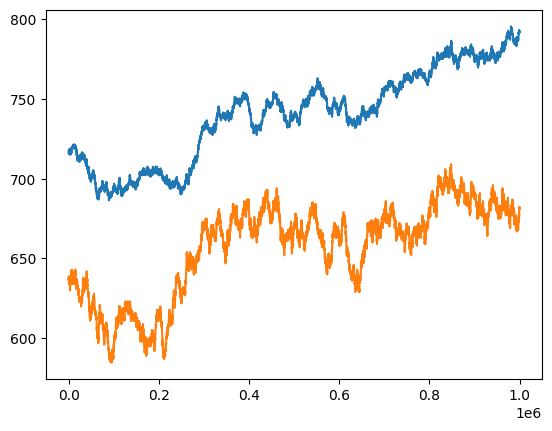

In [8]:
merge_coco['coup_value']= coup_theoretical(merge_coco['mid_price'])
data1_coco['coup_value']= coup_theoretical(data1_coco['mid_price'])
data2_coco['coup_value']= coup_theoretical(data2_coco['mid_price'])
data3_coco['coup_value']= coup_theoretical(data3_coco['mid_price'])



plt.plot(data1_coco.index,data1_coco['coup_value'])#blue
plt.plot(data1_coup.index,data1_coup['mid_price'])#orange


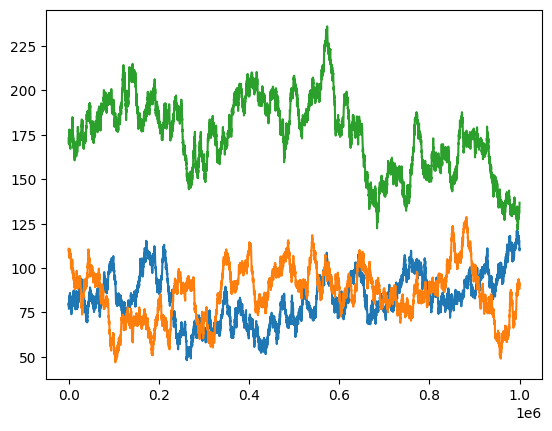

In [9]:
plt.plot(data1_coco.index,data1_coco['coup_value']-data1_coup['mid_price'])#blue
plt.plot(data2_coco.index,data2_coco['coup_value']-data2_coup['mid_price'])#orange
plt.plot(data3_coco.index,data2_coco['coup_value']-data3_coup['mid_price'])#green

#b.s gives a constant premium price

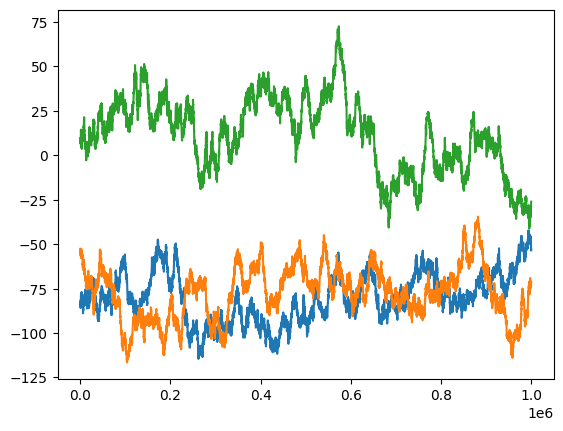

In [10]:
data3_coco['coup_value_low_iv']= coup_theoretical_low_iv(data3_coco['mid_price'])
data1_coco['coup_value_low_iv']= coup_theoretical_low_iv(data1_coco['mid_price'])
data2_coco['coup_value_low_iv']= coup_theoretical_low_iv(data2_coco['mid_price'])

plt.plot(data1_coco.index,data1_coco['coup_value_low_iv']-data1_coup['mid_price'])#blue
plt.plot(data2_coco.index,data2_coco['coup_value_low_iv']-data2_coup['mid_price'])#orange
plt.plot(data3_coco.index,data2_coco['coup_value_low_iv']-data3_coup['mid_price'])#green
#the look of the graphs are effectuvely the same, bar a constant subtraction.

In [11]:
def delta_fn(stock,strike):
    return (stock-strike)/2

def iv_aprox(tau,cmarket,stock,delta):
    return math.sqrt(2*math.pi/tau)*((cmarket-delta)/(stock-delta))

def iv_coup_aprox(cmarket_array,coco_arr):
    iv_arr = []
    for i in range(min(len(cmarket_array),len(coco_arr))):
        iv_arr.append(iv_aprox(250,cmarket_array.iloc[i],coco_arr.iloc[i],delta_fn(coco_arr.iloc[i],10000)))
    return iv_arr

In [12]:
data1_coup['IV'] = iv_coup_aprox(data1_coup['mid_price'],data1_coco['mid_price'])
data2_coup['IV'] = iv_coup_aprox(data2_coup['mid_price'],data2_coco['mid_price'])
data3_coup['IV'] = iv_coup_aprox(data3_coup['mid_price'],data3_coco['mid_price'])
merge_coup['IV'] = iv_coup_aprox(merge_coup['mid_price'],merge_coco['mid_price'])






C:\Users\chris\AppData\Local\Temp\ipykernel_33148\2842285913.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merge_coup['IV'] = iv_coup_aprox(merge_coup['mid_price'],merge_coco['mid_price'])


ValueError: x and y must have same first dimension, but have shapes (29998,) and (9999,)

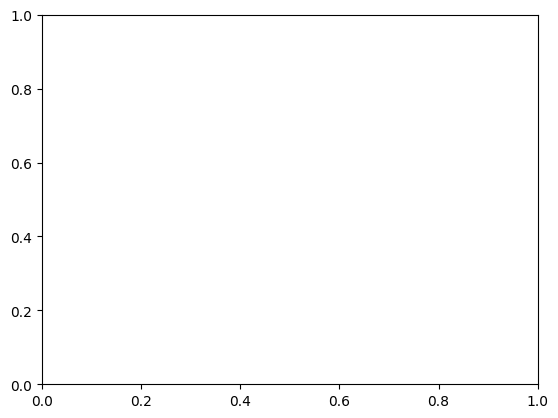

In [13]:
#things to check: if BS price is a signal for coupons or coconuts
#BS price - true price or BSprice/mkt price is stationary
#check if normal distrib is fair for the coconut returns. otherwise fit a new distrib and use monte carlo
#get IV for coupons and check if its a signal or mean reverting.
#find a mean iv across the 3 days and use it to calculate fair value as a signal as opposed to historical volatility.
merge_coup
plt.plot(merge_coup.index,data3_coup['IV'])

merge_coup['IV'].mean()

In [21]:
#iv_calibrator(682.5, 0, 10000, 250,10183, .00001) #.0092 daily IV, 1.1 sec with 1/10th basis point
iv_aprox(250,682.5,10183,delta_fn(10183,10000)) # .009284


0.009284353893415856

In [42]:
exact = []
approx = []
error = []
for i in range(-50,50):
    exact.append(iv_calibrator(682.5+i,0,10000,250,10183+2*i,.00001))
    approx.append(iv_aprox(250,682.5+i,10183+2*i,delta_fn(10183+2*i,10000)))
         
exact,approx    

([0.00932,
  0.00932,
  0.00932,
  0.00932,
  0.00932,
  0.00932,
  0.00931,
  0.00931,
  0.00931,
  0.00931,
  0.00931,
  0.00931,
  0.009300000000000001,
  0.009300000000000001,
  0.009300000000000001,
  0.009300000000000001,
  0.009300000000000001,
  0.009290000000000001,
  0.009290000000000001,
  0.009290000000000001,
  0.009290000000000001,
  0.009290000000000001,
  0.00928,
  0.00928,
  0.00928,
  0.00928,
  0.00928,
  0.00927,
  0.00927,
  0.00927,
  0.00927,
  0.00927,
  0.009260000000000001,
  0.009260000000000001,
  0.009260000000000001,
  0.009260000000000001,
  0.009250000000000001,
  0.009250000000000001,
  0.009250000000000001,
  0.009250000000000001,
  0.009250000000000001,
  0.00924,
  0.00924,
  0.00924,
  0.00924,
  0.00923,
  0.00923,
  0.00923,
  0.00923,
  0.00922,
  0.00922,
  0.00922,
  0.00922,
  0.009210000000000001,
  0.009210000000000001,
  0.009210000000000001,
  0.009210000000000001,
  0.009200000000000002,
  0.009200000000000002,
  0.009200000000000002,
  

In [45]:
error = []
for i in range(len(exact)):
    error.append(abs(exact[i]-approx[i]))
    
error

[1.0583808734362238e-05,
 9.65469906956569e-06,
 8.725774421874943e-06,
 7.797034736035588e-06,
 6.868479956807089e-06,
 5.940110028974932e-06,
 1.5011924897348483e-05,
 1.4083924506752207e-05,
 1.3156108802038838e-05,
 1.2228477728084067e-05,
 1.130103122977573e-05,
 1.0373769252036355e-05,
 1.9446691739801944e-05,
 1.851979863803227e-05,
 1.759308989171017e-05,
 1.6666565445839707e-05,
 1.5740225245447492e-05,
 2.481406923558055e-05,
 2.3888097361309674e-05,
 2.2962309567725256e-05,
 2.203670579993891e-05,
 2.1111286003090007e-05,
 3.0186050122333122e-05,
 2.9260998102846603e-05,
 2.8336129889831863e-05,
 2.7411445428509804e-05,
 2.648694466412735e-05,
 3.556262754194836e-05,
 3.4638494007260476e-05,
 3.371454400537266e-05,
 3.279077748161684e-05,
 3.186719438134401e-05,
 4.0943794649932544e-05,
 4.002057823277588e-05,
 3.909754507529055e-05,
 3.817469512291949e-05,
 4.7252028321120854e-05,
 4.6329544615378304e-05,
 4.540724395119683e-05,
 4.448512627410264e-05,
 4.3563191529642775e-

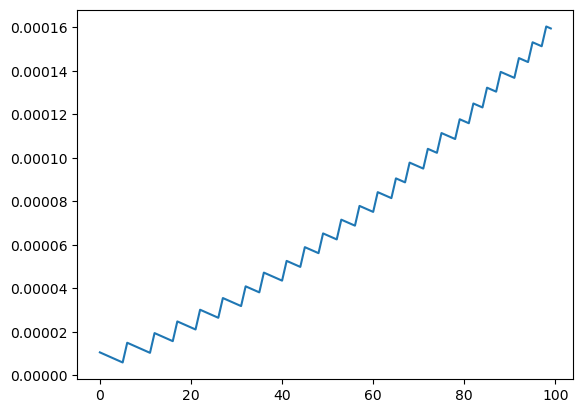

In [46]:
plt.plot(range(100),error)